<a href="https://colab.research.google.com/github/anaguilarar/CC_Weight_Prediction/blob/main/2_Individual_plant_image_processing%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Individual Plant Image Processing: 

This notebook focuses on the processing steps that were applied to each individual plant images, the process includes:

- Plant height image
- vegetation indices
- Data imputation
- Soil mask: PCA and k-means clustering
- export images as array


In [1]:
import os
## clonning repositories
if not os.path.exists("/content/drone_data") and not os.getcwd().endswith("/content/drone_data"):
    !git clone https://github.com/anaguilarar/drone_data.git
    print("Cloned")
    
else:
    print("drone_data directory already exists")

Cloning into 'drone_data'...
remote: Enumerating objects: 1099, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 1099 (delta 65), reused 72 (delta 32), pack-reused 988
Receiving objects: 100% (1099/1099), 17.08 MiB | 13.94 MiB/s, done.
Resolving deltas: 100% (818/818), done.
Cloned


In [2]:
## installing packages
!pip install -r /content/drone_data/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.6/852.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 21.1 MB/s eta 0:00:00


### Data downloading
The data that we will use as an example are 10 individual plant images. Each image is conformed by a 4-Dimensional array (time points, Channels, Height, Width). The data was saved as pickle file. The data used in the paper is partially availble in a google drive folder. Thus, the information will be uploaded to the colab storage using the folowing cell.

In [3]:
import tqdm
def download_from_drive(urlid, drive):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(urlid)}).GetList()
  if len(file_list)>0:
    for j in tqdm.tqdm(range(len(file_list)), leave  = False):
      linkto = file_list[j]['id']
      file_listsub = drive.ListFile({'q': "'{}' in parents and trashed=false".format(linkto)}).GetList()
      if len(file_listsub)>0:
        foldername = file_list[j]['title']
        if not os.path.exists(foldername):
          os.mkdir(foldername)
        os.chdir(foldername)
        download_from_drive(linkto, drive)
        os.chdir('..')

      else:
        #for i, file in enumerate(sorted(file_list, key = lambda x: x['title']), start=1):
        file = file_list[j]
        
        file.GetContentFile(file['title'])

In [4]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

individualplantimagery = '1t9G7km3gf8Ufj_f3PZmlTWYjGofhKmL1'
spatial_boundaries = '1YjKEgdUJ5edicNMNbevox4rXPPosbPDp'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
## this is gonna take few minutes
for linktod in [spatial_boundaries, individualplantimagery]:
  download_from_drive(linktod, drive)
 

### Plant height image

In the individual plant image channels, there is a dedicated channel for representing plant height values. However, it is important to note that these values do not accurately reflect the true plant height. To obtain the actual plant height values, a reference point was established using soil height values. By subtracting this reference height from the height values captured at different time points, we derived the true plant height values. The soil reference point is located in the first time point image.


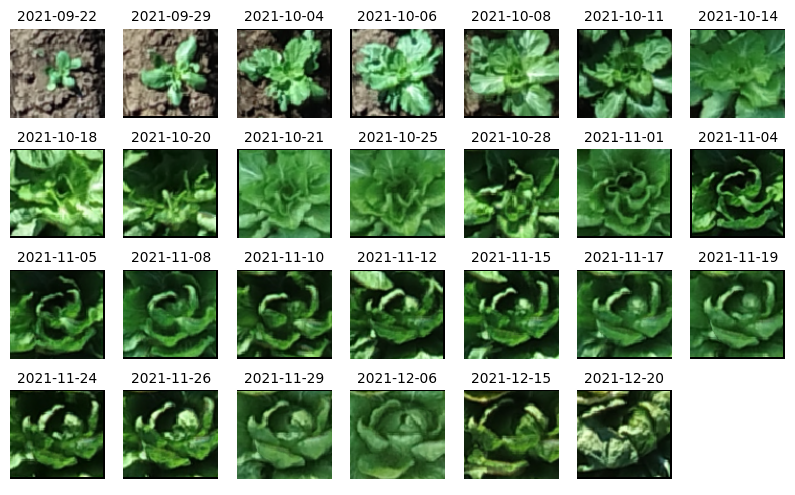

In [5]:
from drone_data.utils.xr_functions import CustomXarray
from drone_data.utils.plt_functions import plot_multitemporal_rgb

## selecting a pickle file
path = "/content/"
fn = [i for i in os.listdir(path) if i.endswith('.pickle')][0]
## reading the data as an xarray file
xrfile = CustomXarray(file = os.path.join(path,fn), customdict=True)

f = plot_multitemporal_rgb(xrfile.xrdata, bands = ['red','green','blue'],
                           nrows = 4,ncols = 7,fontname = None, figsize = (10,6), fontsize = 10)


#### Getting the soil reference value 

The soil reference value is the 90 % distribution of the height values


reference altitude 96.58024978637695 m


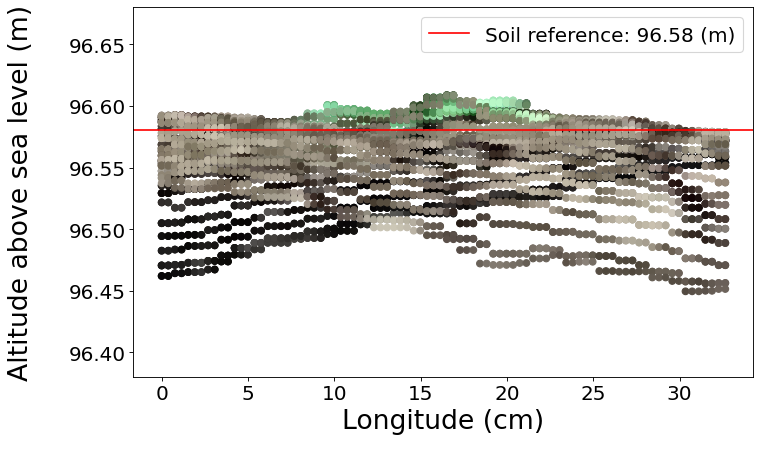

In [7]:
from drone_data.utils.xyz_functions import get_baseline_altitude
import matplotlib.pyplot as plt
import numpy as np

## getting basereference
xrtestdf = xrfile.xrdata.isel(date = 0).to_dataframe()
altref = xrtestdf.reset_index().loc[:,('x','y','z','red','green','blue')].dropna()
bsl = get_baseline_altitude(altref, method='max_probability')
print('reference altitude {} m'.format(bsl))

## ploting
indcolors = [[r/255.,g/255.,b/255.] for r,g,b in zip(
                 altref.iloc[:,3].values, 
                 altref.iloc[:,4].values,
                 altref.iloc[:,5].values)]

plt.figure(figsize=(10, 6), dpi=80)
xaxisvals = altref.iloc[:,1].copy()

plt.scatter((xaxisvals - np.min(xaxisvals)) * 100,
            altref.iloc[:,2],
            c = indcolors)

plt.axhline(y = bsl, color = 'r', linestyle = '-', label = 'Soil reference: {:.2f} (m)'.format(bsl))
plt.ylim(bsl-.2, bsl+.10)
plt.yticks(fontsize=18)
plt.ylabel('Altitude above sea level (m)\n', fontsize=24)

plt.xticks(fontsize=18)
plt.xlabel('Longitude (cm)\n', fontsize=24)


plt.legend(loc="upper left")
plt.legend(fontsize=18)


#### Substraing the soil reference value

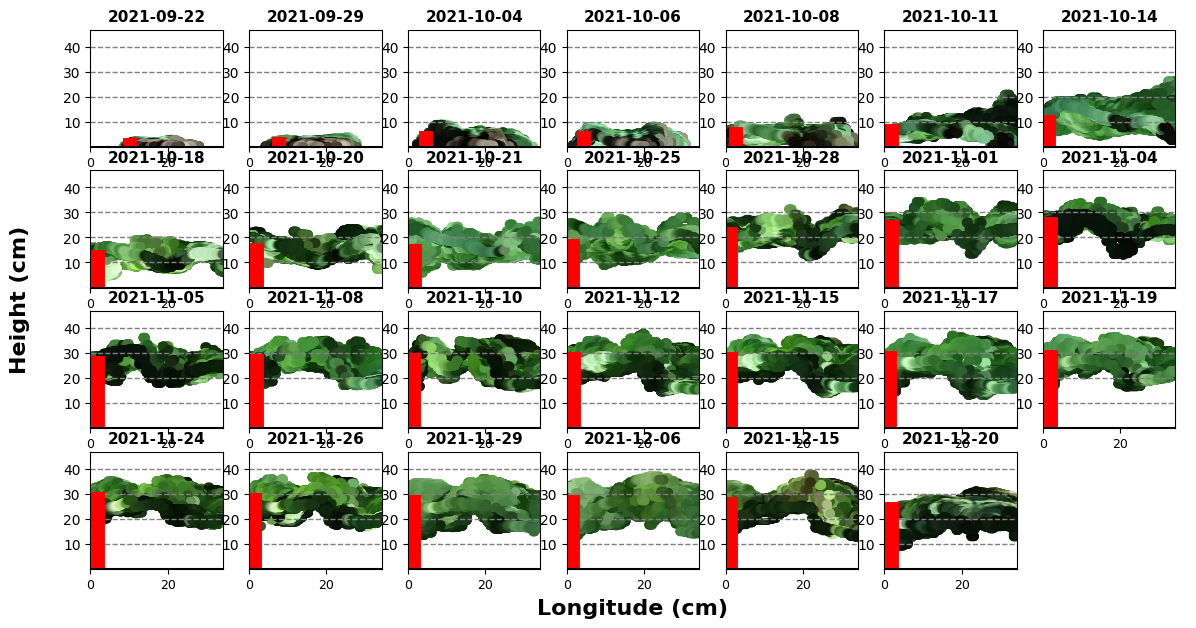

In [10]:
from drone_data.utils.plt_functions import plot_heights
## p
f = plot_heights(xrfile.xrdata.copy(), bsl = bsl, fontname = None, num_rows = 4, num_columns=7, figsize = (14,9), fontsize = 11,yfontize=10)

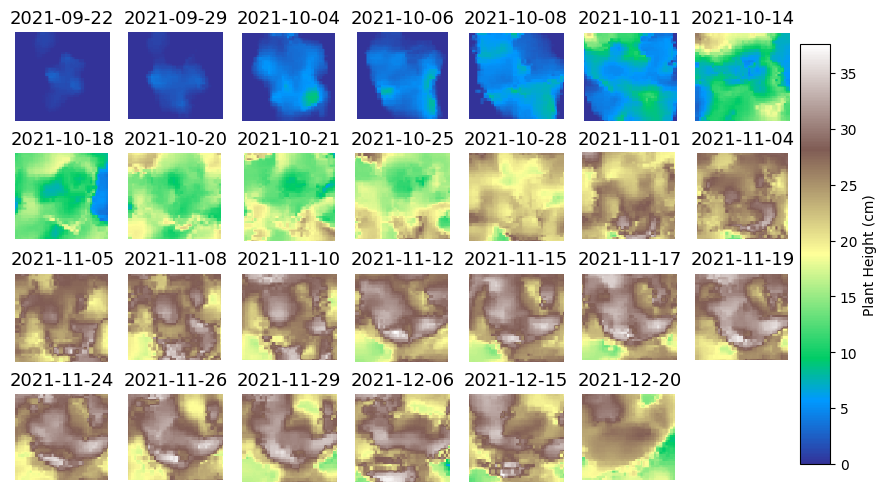

In [ ]:
from drone_data.utils.plt_functions import plot_multichanels
### zenith visualization

xrtest = xrfile.xrdata.copy()
xrtest['z'] = (xrtest.z - bsl)*100
xrtest['z'] = xrtest.z.where(np.logical_or(np.isnan(xrtest.z),xrtest.z > 0 ), 0)
datesstr = [np.datetime_as_string(i, unit='D') for i in xrtest.date.values ]

figmod,axmod = plot_multichanels(xrtest.z.values, cmap = 'terrain', num_rows= 4, num_columns= 7,chanels_names=datesstr,
                figsize=(10,6),label_name = 'Plant Height (cm)',legfontsize=10,legtickssize=10,fontsize=13, fontname = None)


### Vegetation indices

The next step was to comput and filter vegetation indices. Among the different vegetation indices that are avaiable in the repository, we can compute:

- GRVI: [Red and photographic infrared linear combinations for monitoring vegetation](https://www.sciencedirect.com/science/article/pii/0034425779900130)$$\frac{green - red}{green + red}$$
- MGRVI: [modified green red vegetation index](https://www.sciencedirect.com/science/article/pii/S0303243415000446)$$ \frac{green^2 - red^2}{green^2 + red^2} $$
- RGBVI: [Red Green Blue Vegetation Index](https://www.sciencedirect.com/science/article/pii/S0303243415000446)$$ \frac{(green^2) - (blue*red)}{(green^2) + (blue * red)} $$
- NDVI: [normalized difference vegetation index](https://books.google.co.jp/books?hl=en&lr=&id=e00CAAAAIAAJ&oi=fnd&pg=PA309&ots=JTQteVFm-b&sig=3JNqoOLVGDRe1LNfodW_3T7K9uI&redir_esc=y#v=onepage&q&f=false)$$\frac{nir - red}{red + nir}$$
- NDRE: [normalized difference red edge index](https://www.sciencedirect.com/science/article/pii/S0176161704704034?via%3Dihub)$$\frac{nir - edge}{red + edge}$$
- GNDVI: [green normalized difference vegetation index](https://www.sciencedirect.com/science/article/pii/S0176161704704034?via%3Dihub)$$\frac{nir - green}{red + green}$$
- RECI: [red edge chlorophyll index](https://www.sciencedirect.com/science/article/pii/S0176161704704034?via%3Dihub)$$(\frac{nir}{edge} - 1)$$
- RECI: nir - rededge - green index $$ \frac{(nir^2) - (edge*green)}{(nir^2) + (edge * green)} $$

For the paper we calculated 13 indices comabining information from the RGB and MS cameras

the VI gndvi was calculated before ['red', 'green', 'blue', 'blue_ms', 'green_ms', 'red_ms', 'edge', 'nir', 'z', 'red_3d', 'green_3d', 'blue_3d', 'grvi', 'mgrvi', 'rgbvi', 'grvi_rgb', 'mgrvi_rgb', 'rgbvi_rgb', 'gndvi', 'savi', 'ndre']
the VI gndvi was calculated before ['red', 'green', 'blue', 'blue_ms', 'green_ms', 'red_ms', 'edge', 'nir', 'z', 'red_3d', 'green_3d', 'blue_3d', 'grvi', 'mgrvi', 'rgbvi', 'grvi_rgb', 'mgrvi_rgb', 'rgbvi_rgb', 'gndvi', 'savi', 'ndre']


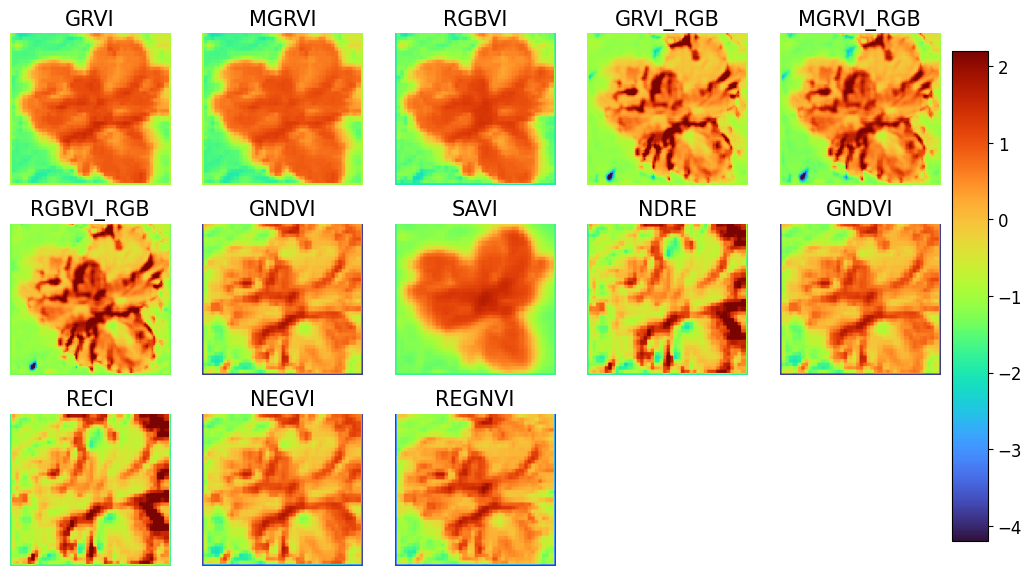

In [73]:
from drone_data.utils.general import MSVEGETATION_INDEX ## this contains the list of equations
from drone_data.utils.drone_data import calculate_vi_fromxarray
from drone_data.utils.data_processing import data_standarization


vilist = ["grvi", "mgrvi", "rgbvi","grvi_rgb","mgrvi_rgb","rgbvi_rgb","gndvi","savi","ndre","gndvi","reci","negvi","regnvi"]

ipi_files = [i for i in os.listdir(path) if i.endswith('.pickle')]

ipi = CustomXarray(file = os.path.join(path,ipi_files[0]), customdict=True)
ipivi = ipi.xrdata.copy()
for vi in vilist:
    ipivi = calculate_vi_fromxarray(ipivi,vi = vi,expression = MSVEGETATION_INDEX[vi])

ipivi = ipivi[vilist].copy()


tp = 3
f = plot_multichanels([data_standarization(ipivi[vi].isel(date = tp)).to_numpy() for vi in vilist], figsize= (12,7),
                                num_rows= 3, num_columns=5,  
                                chanels_names = [viname.upper() for viname in vilist] if tp == 3 else ["".join(([" "] * len(viname))) for viname in vilist],
                                cmap="turbo", 
                                fontname=None, fontsize = 15,legtickssize=12,
                                vmax= 2.2,
                                vmin = -4.2)


### Noise Filtering

#### RGB: histogram equalization

increase the contrast in the image
https://en.wikipedia.org/wiki/Histogram_equalization

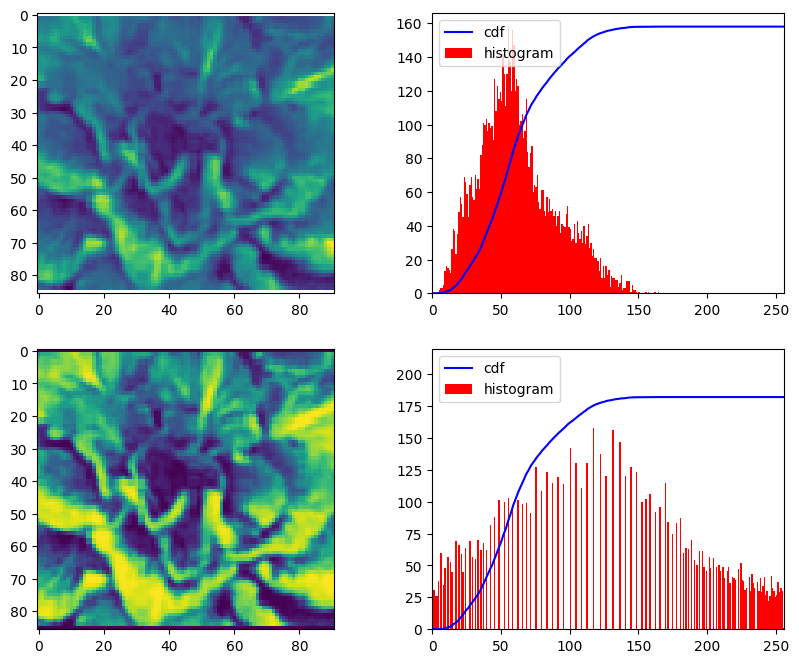

In [ ]:
from drone_data.utils.image_functions import hist_equalization
from drone_data.utils.gis_functions import hist_ndxarrayequalization
from matplotlib import pyplot as plt
img = xrfile.xrdata.copy().red.isel(date = 10).values
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize = (10,8))
ax[0,1].plot(cdf_normalized, color = 'b')
ax[0,0].imshow(img)
ax[0,1].hist(img.flatten(),256,[0,256], color = 'r')
ax[0,1].set_xlim([0,256])
ax[0,1].legend(('cdf','histogram'), loc = 'upper left')
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
img2 = hist_equalization(img)
ax[1,0].imshow(img2)
ax[1,0].set_title('after equalization')
hist2,bins2 = np.histogram(img.flatten(),256,[0,256])
cdf2 = hist.cumsum()
cdf_normalized2 = cdf2 * float(hist2.max()) / cdf2.max()
ax[1,1].plot(cdf_normalized2, color = 'b')
ax[1,1].hist(img2.flatten(),256,[0,256], color = 'r')
ax[1,1].set_xlim([0,256])
ax[1,1].legend(('cdf','histogram'), loc = 'upper left')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


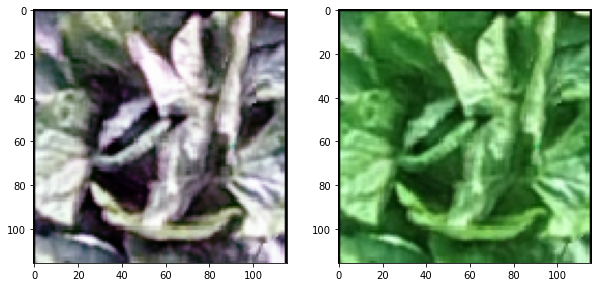

In [ ]:
dateoi = 20
img = xrexample.isel(date = dateoi)[['red','green','blue']].to_array().values

xrtest = hist_ndxarrayequalization(xrexample, bands = ['red','green','blue'])
mex = xrtest.isel(date = dateoi)[['red_eq','green_eq','blue_eq']].to_array().values

fig, ax = plt.subplots(nrows=1,ncols = 2, figsize = (10,5))

ax[0].imshow(mex.swapaxes(0,1).swapaxes(1,2).astype(int))
ax[1].imshow(img.swapaxes(0,1).swapaxes(1,2).astype(int))


#### Soil mask

In order to obtain only useful information that represents Chinese cabbage, it was necessary to remove those pixels that contain information related to soil or noise. We proposed used a kmeans model to mask the soil pixels. The kmeans was trained using only vegetation indices.
##### Extract data from a sample of polygons/plants

From each plant frames we will extract data realted to indexes like rgbvi ndvi savi ndre and gndvi, those indexes are commly sued for ccover classification. From the total of data acrros the time a 40 percent will be used for training the k means model. the k-means model was trained after scaling the initial data set using a  min max approach and after 


In [ ]:
xrfiles = [i for i in os.listdir(path) if i.endswith('.pickle')]

In [ ]:

finallistvi = ['rgbvi', 'savi','ndvi', 'ndre', 'gndvi']

listdf = []
persample = 80
seed=123

for i in tqdm.tqdm(range(0,len(xrfiles))):
    
    xrfile = xrfiles[i]
    
    with open(os.path.join(INPUTFOLDER,xrfile),"rb") as f:
        xrdata= pickle.load(f)
        
    xrtestvi = xrdata.copy()
    for vi in finallistvi:
        xrtestvi = calculate_vi_fromxarray(xrtestvi,vi = vi,expression = VEGETATION_INDEX[vi])

    xrsingle = xrtestvi[finallistvi].isel(date = DATESTOSELECT).copy()
    #xrsingle['plant'] = i
    xrdf = xrsingle.to_dataframe().dropna().drop(['spatial_ref'],axis = 1)

    nsample = int(np.round(xrdf.shape[0] * (persample / 100)))
    listdf.append(xrdf.sample(n=nsample, random_state=seed))
    
listdf = pd.concat(listdf)

100%|██████████| 385/385 [02:13<00:00,  2.89it/s]


#### K-means clustering

The process is done through several steps:
 - extracting vegetation values from individual plant image (IPI)
 - data normalization
 - pca reduction
 - kmeans

In [21]:
from drone_data.utils.classification_functions import kmeans_images
from drone_data.utils.general import MSVEGETATION_INDEX
import pandas as pd


#### Data extraction
From each plant frames we will extract data realted to indexes like rgbvi ndvi savi ndre and gndvi, those indexes are commly sued for ccover classification. From the total of data acrros the time a 40 percent will be used for training the k means model. the k-means model was trained after scaling the initial data set using a  min max approach and after 

In [12]:
DATETODELETE = 4 ## the fourth image will be deleted, this image was affected by brigthness
DATESTOSELECT =  list(range(0,DATETODELETE)) + list(range(DATETODELETE+1,27)) 

In [23]:
### getting vegetation indices values
finallistvi = ['rgbvi', 'savi','ndvi', 'ndre', 'gndvi']
ipi_files = [i for i in os.listdir(path) if i.endswith('.pickle')]

listdf = []
persample = 80
seed=123
for i in tqdm.tqdm(list(range(len(ipi_files)))):

    ipi = CustomXarray(file = os.path.join(path,ipi_files[i]), customdict=True)
    ipivi = ipi.xrdata.copy()
    for vi in finallistvi:
        ipivi = calculate_vi_fromxarray(ipivi,vi = vi,expression = MSVEGETATION_INDEX[vi])

    ipivi = ipivi[finallistvi].isel(date = DATESTOSELECT).copy()
    #xrsingle['plant'] = i
    xrdf = ipivi.to_dataframe().dropna()

    nsample = int(np.round(xrdf.shape[0] * (persample / 100)))
    listdf.append(xrdf.sample(n=nsample, random_state=seed))
  
listdf = pd.concat(listdf)


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

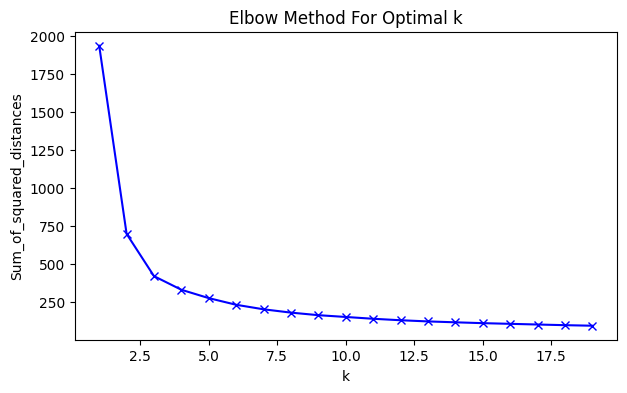

In [25]:
### selecting number of cluster using the elbow method
listdfsample = listdf.sample(n=10000, random_state=123)
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    Sum_of_squared_distances.append(
        kmeans_images(listdfsample.reset_index().drop(['x','y','date'],axis = 1).values, k)['kmeans_model'].inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [26]:
## k-means model
kmeanmodel_soil =[]
#del listxarraycor_vi
nsample = int(np.round(listdf.shape[0] * (40 / 100)))
kmeanmodel_soil = kmeans_images(listdf.reset_index().drop(['x','y','date'],axis = 1),5, nrndsample=nsample, eigmin=0.6,export_pca=True,  verbose=True)

scale done!
kmeans training using a 1182721 x 2 matrix


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<ipython-input-27-424c24195106>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('turbo', (len(np.unique(kmeanmodel_soil['labels']))+1))


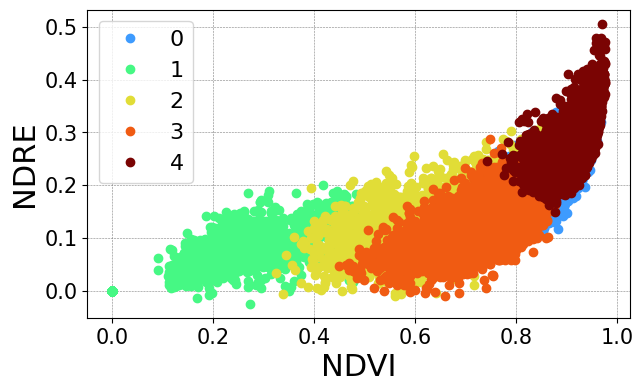

In [27]:
### plotting cluster point distribution

import matplotlib
cmap = matplotlib.cm.get_cmap('turbo', (len(np.unique(kmeanmodel_soil['labels']))+1))

listdfsample = listdf.reset_index()#.sample(n=100000, random_state=123).copy()
listdfsample['labels'] = kmeanmodel_soil['labels'][listdfsample.index]
listdfsample = listdfsample.sample(n=30000, random_state=123)
groups = listdfsample.groupby("labels")
plt.figure(figsize=(7,4))
count = 1
for name, group in groups:
    
    plt.plot(group["ndvi"], group["ndre"], 
             marker="o", linestyle="", 
             label=name+0, color =matplotlib.colors.rgb2hex(cmap(count)))
    count+=1
#plt.ylim(-0.05, 0.5)
#plt.xlim(0.05, 1)
plt.xlabel('NDVI', fontsize=22)
plt.ylabel('NDRE', fontsize=22)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.4)

plt.legend(fontsize=16)



#### cluster classification

In [36]:
from drone_data.utils.classification_functions import cluster_4dxarray
from drone_data.utils.plt_functions import plot_multichanels

import matplotlib


In [33]:
kmeanmodel_soil['variable_names'] = finallistvi

In [41]:
ipi = CustomXarray(file = os.path.join(path,ipi_files[i]), customdict=True)
ipivi = ipi.xrdata.copy()
for vi in finallistvi:
    ipivi = calculate_vi_fromxarray(ipivi,vi = vi,expression = MSVEGETATION_INDEX[vi])

ipivi = ipivi.isel(date = DATESTOSELECT).copy()


xrimage ,xrcluster = cluster_4dxarray(ipivi.copy(),cl_dict = kmeanmodel_soil, 
                                      cluster_value= 2, 
                                      only_thesedates=[0,1,2,3,4,5,6])



<ipython-input-39-07ac333c4429>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('turbo', (len(np.unique(kmeanmodel_soil['labels']))+1))


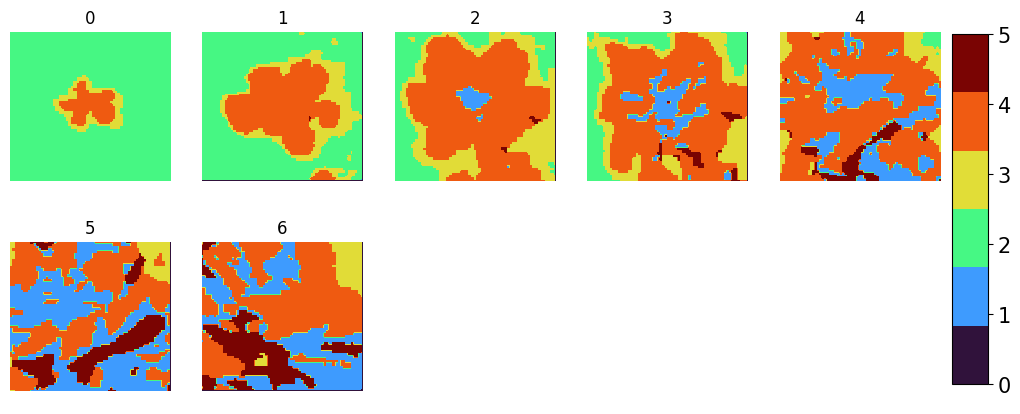

In [39]:

cmap = matplotlib.cm.get_cmap('turbo', (len(np.unique(kmeanmodel_soil['labels']))+1))
f = plot_multichanels(xrcluster.values, num_columns=5, num_rows=2, cmap = cmap, figsize=(12,5), fontname = None)


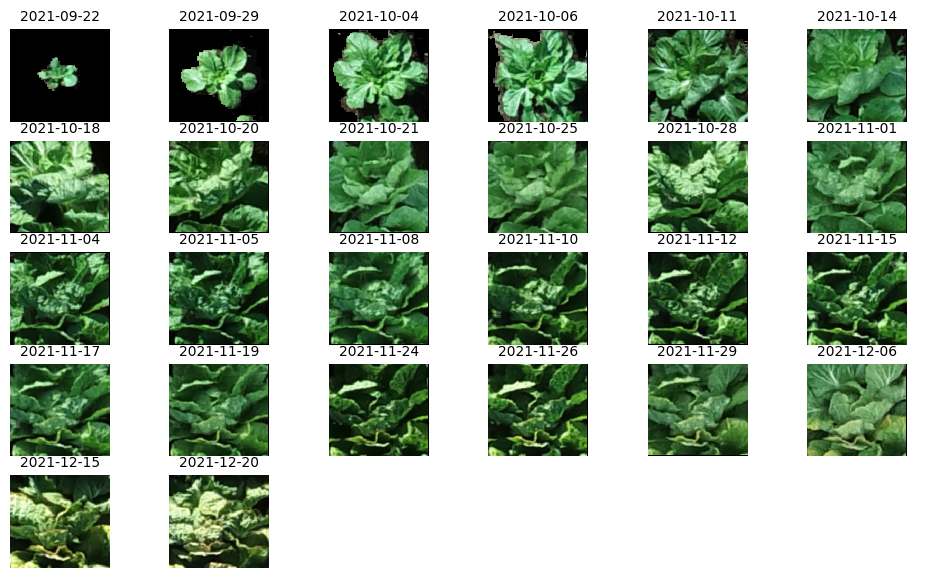

In [45]:
figtoexport = plot_multitemporal_rgb(xrimage, nrows= 5, figsize=(12,7), fontname = None, fontsize = 10)


### small pixels filtering

In [46]:
from drone_data.utils.xr_functions import filter_3Dxarray_contourarea

In [47]:
xrmasked = filter_3Dxarray_contourarea(xrimage.copy())

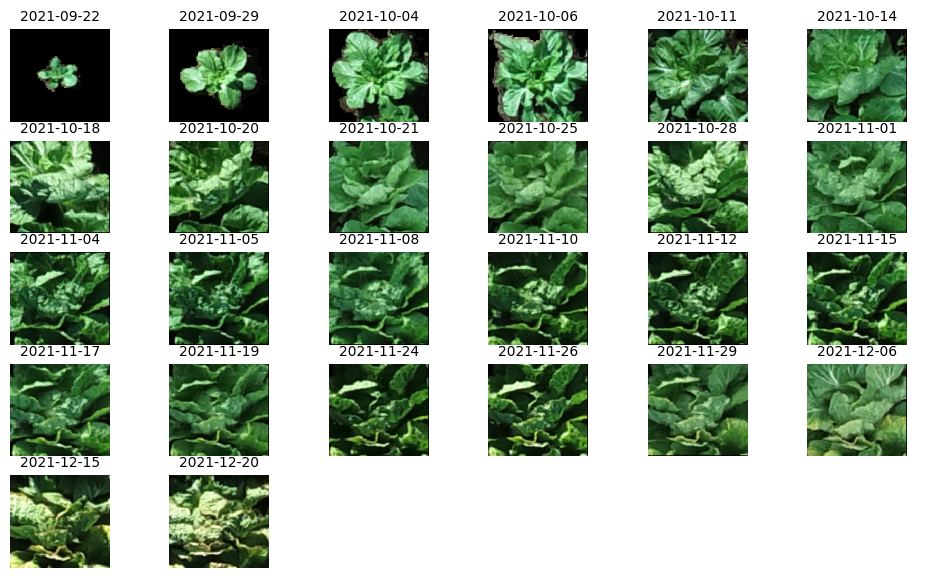

In [48]:
figtoexport = plot_multitemporal_rgb(xrmasked, nrows= 5, figsize=(12,7), fontname = None, fontsize = 10)

### image centering

In [65]:
from drone_data.utils.gis_functions import get_filteredimage

uavdatamasked_red = get_filteredimage(xrmasked, 
                                        channel = 'z',
                                        red_perc = 70, 
                                        refimg = 0, 
                                        clip_xarray=True)

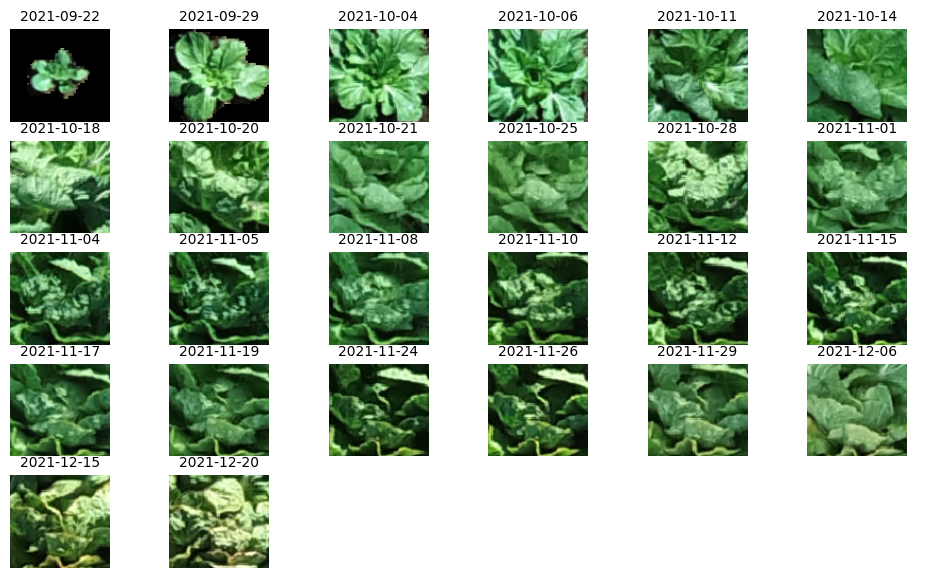

In [67]:
from drone_data.utils.plt_functions import plot_multitemporal_rgbarray

xrdatac = uavdatamasked_red[['red','green','blue']].to_array().values.copy()
datelabesl = [np.datetime_as_string(i, unit='D') for i in uavdatamasked_red['date'].values] 

figtoexport = plot_multitemporal_rgbarray(xrdatac.copy(), nrows= 5,ncols = 6, figsize=(12,7), fontname = None, datelabes = datelabesl,fontsize = 10, depthpos = 1)
